In [1]:
import torch
import numpy as np

import matplotlib.pyplot as plt

# from mlcolvar.cvs import BaseCV
# from mlcolvar.core import FeedForward, Normalization


In [2]:
n_particles = 22
n_dimensions = 3
dim = n_particles * n_dimensions

atom_types = np.arange(22)
atom_types[[1, 2, 3]] = 2
atom_types[[19, 20, 21]] = 20
atom_types[[11, 12, 13]] = 12
h_initial = torch.nn.functional.one_hot(torch.tensor(atom_types))

In [3]:
cv_param_list = []
for i in range(0, 1000, 100):
	load_path = f"./models/FM-AD2-train-cv_250n_{i}"
	print(f"Loading model from {load_path}")
	cv_model = torch.load(load_path)
	cv_param_list.append(cv_model)

Loading model from ./models/FM-AD2-train-cv_250n_0
Loading model from ./models/FM-AD2-train-cv_250n_100
Loading model from ./models/FM-AD2-train-cv_250n_200
Loading model from ./models/FM-AD2-train-cv_250n_300
Loading model from ./models/FM-AD2-train-cv_250n_400
Loading model from ./models/FM-AD2-train-cv_250n_500
Loading model from ./models/FM-AD2-train-cv_250n_600
Loading model from ./models/FM-AD2-train-cv_250n_700
Loading model from ./models/FM-AD2-train-cv_250n_800
Loading model from ./models/FM-AD2-train-cv_250n_900


In [4]:
# Extract parameters and analyze their changes
param_changes = {}

# Get all parameter names from the first state dict
param_names = list(cv_param_list[0].keys())

# For each parameter, track its changes over epochs
for param_name in param_names:
    param_changes[param_name] = {
        'mean': [],
        'std': [],
        'max': [],
        'min': []
    }
    
    for state_dict in cv_param_list:
        param_tensor = state_dict[param_name].cpu().numpy()
        param_changes[param_name]['mean'].append(np.mean(param_tensor))
        param_changes[param_name]['std'].append(np.std(param_tensor))
        param_changes[param_name]['max'].append(np.max(param_tensor))
        param_changes[param_name]['min'].append(np.min(param_tensor))

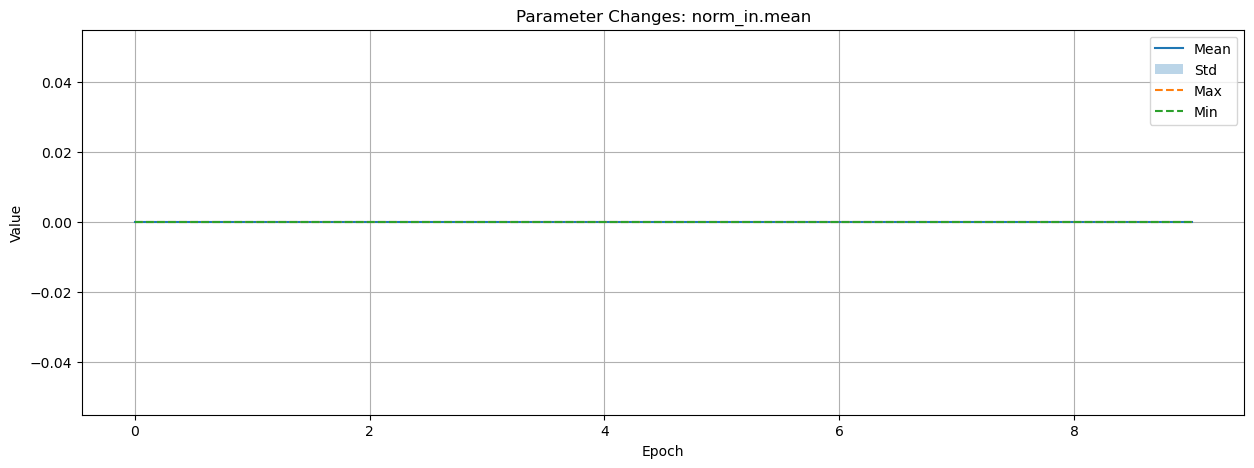

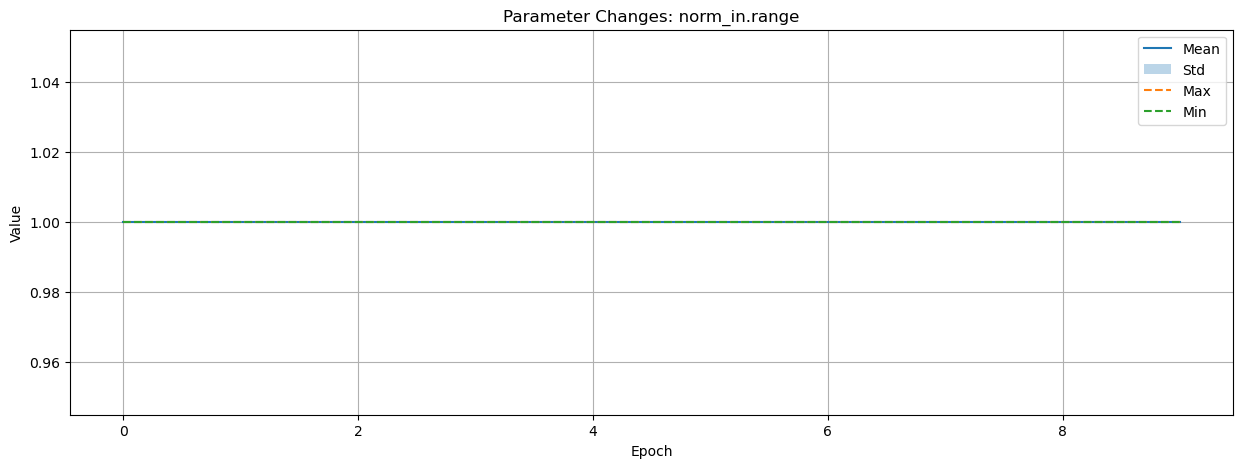

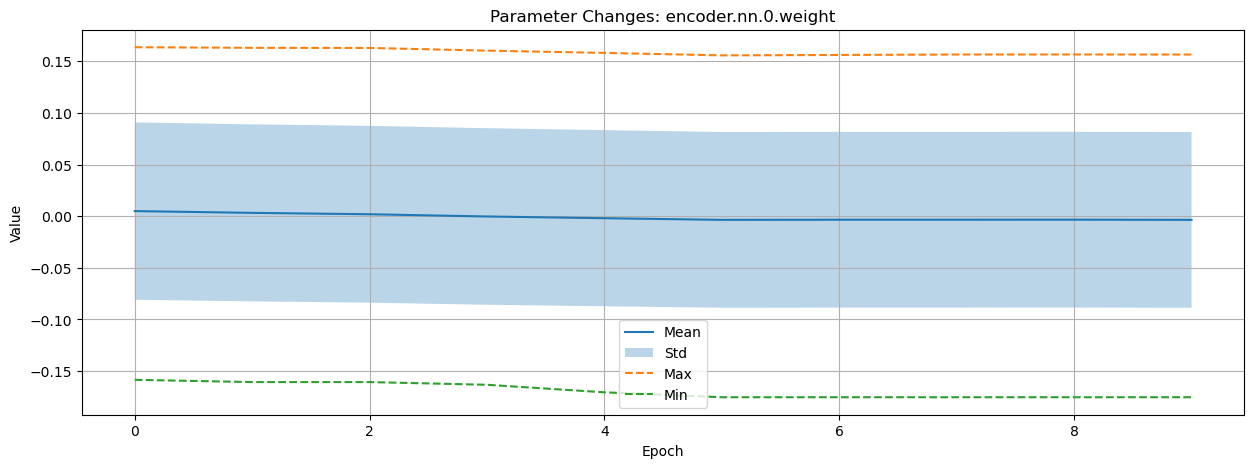

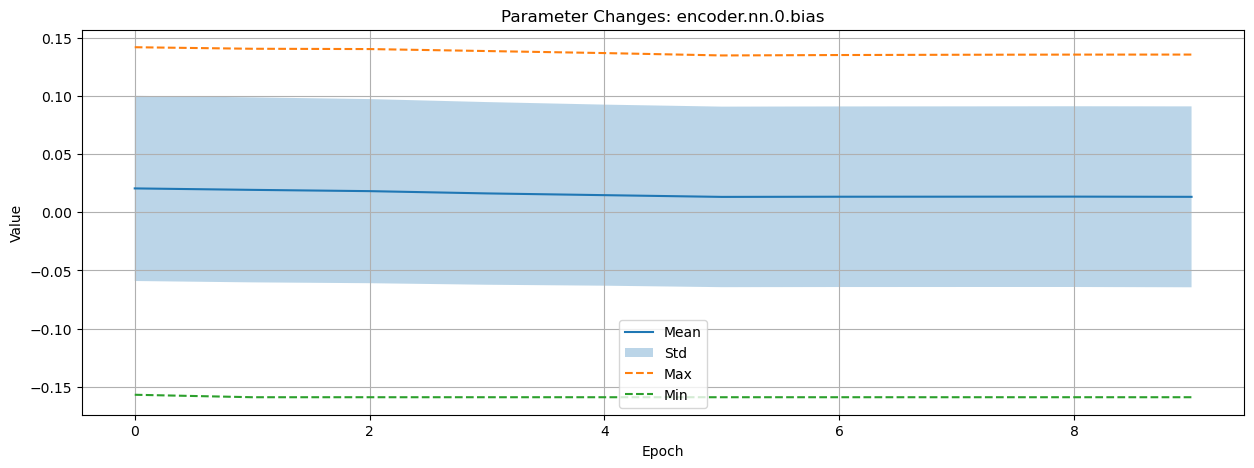

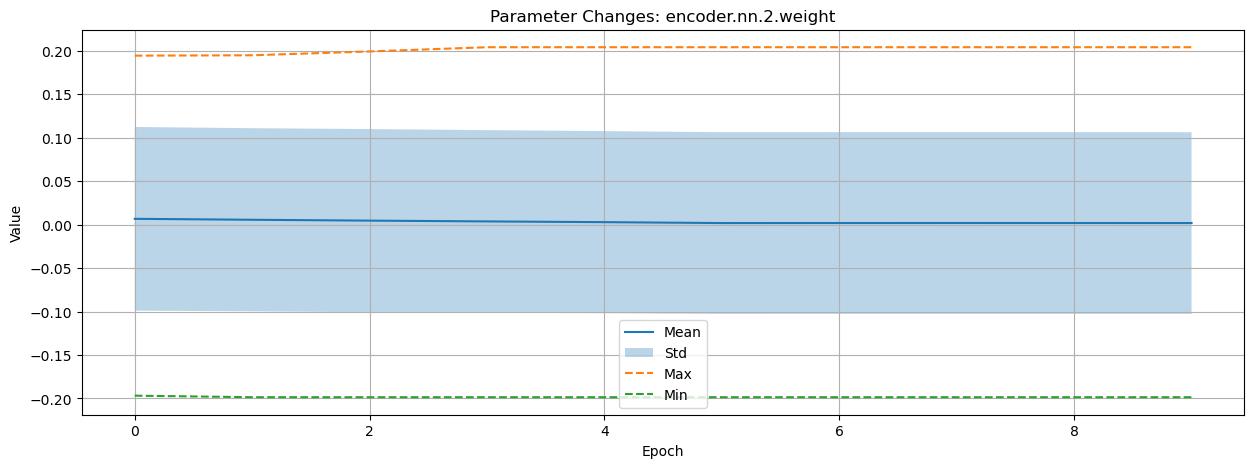

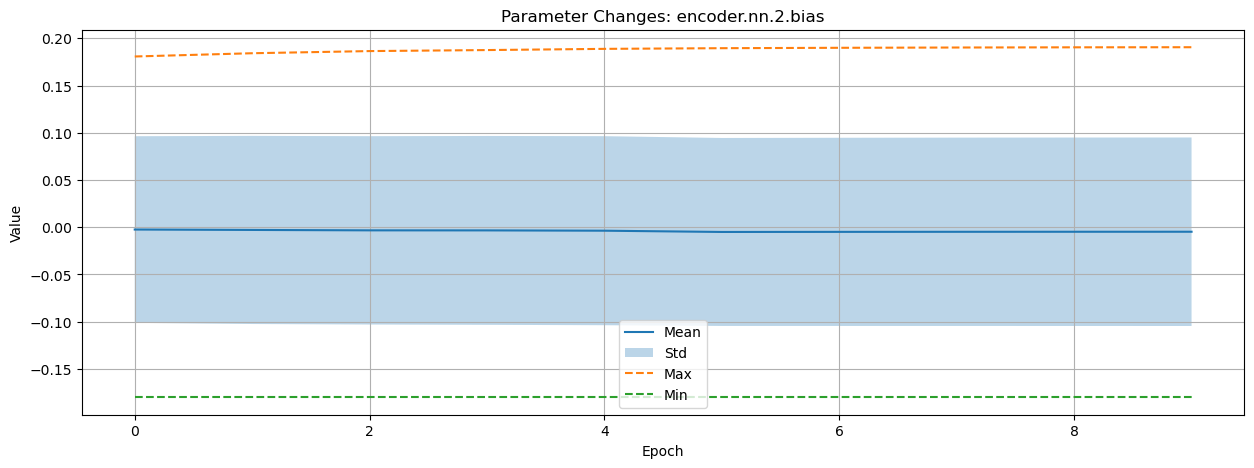

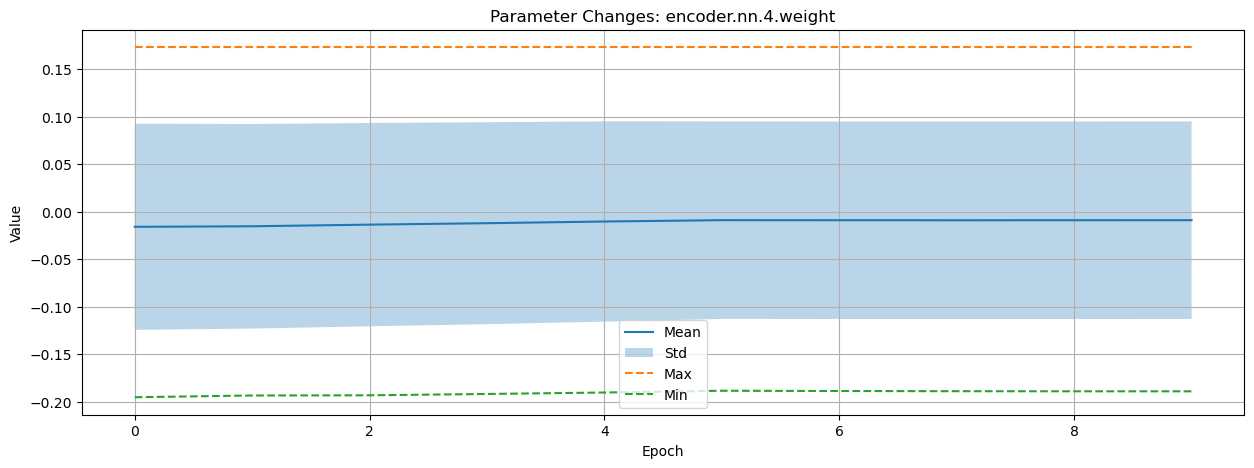

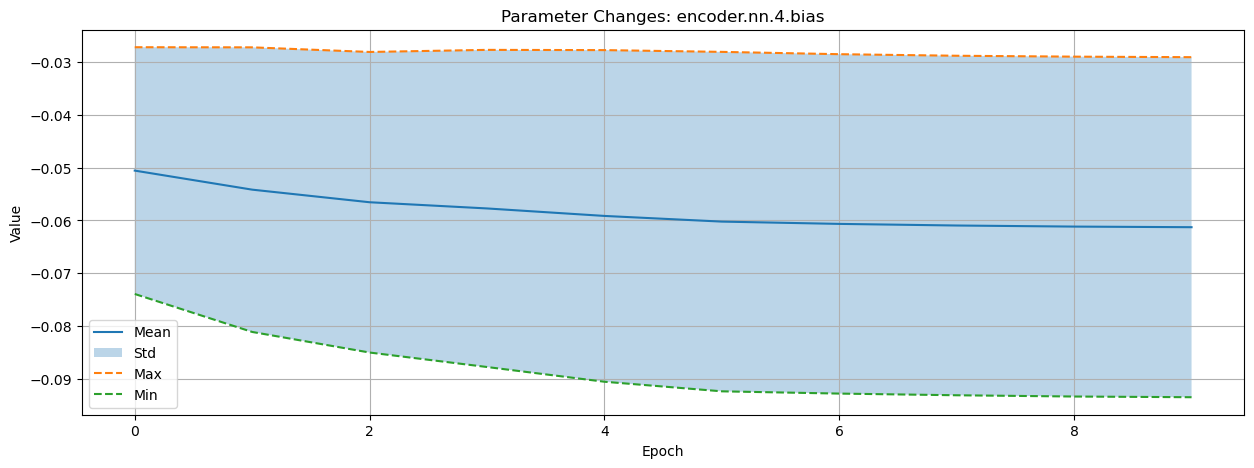

In [5]:
# Plot the changes for each parameter
idx = np.arange(len(cv_param_list))
for param_name in param_names:
    plt.figure(figsize=(15, 5))
    
    plt.plot(idx, param_changes[param_name]['mean'], label='Mean')
    plt.fill_between(idx,
		np.array(param_changes[param_name]['mean']) - np.array(param_changes[param_name]['std']),
		np.array(param_changes[param_name]['mean']) + np.array(param_changes[param_name]['std']),
		alpha=0.3, label='Std'
	)
    plt.plot(idx, param_changes[param_name]['max'], '--', label='Max')
    plt.plot(idx, param_changes[param_name]['min'], '--', label='Min')
    
    plt.title(f'Parameter Changes: {param_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()